In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import warnings

import spikeinterface.full as si
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

sys.path.append("/home/phornauer/Git/spikesorting/")
from spikesorting import unit_match as um

warnings.filterwarnings("ignore", category=RuntimeWarning)

si.set_global_job_kwargs(n_jobs=24, progress_bar=False)

In [3]:
parent_path = '/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/'
project_name = 'Torsten_2'
recording_date = '241114'
chip_id = 'T002523'
assay_name = 'Network'
assay_id = '*'

param = {
    'spike_width': 30, # in samples
    'waveidx': np.arange(5,15), # index of the waveform to be used for the metric
    'peak_loc': 10, # index of the peak location in the waveform
    'no_shanks': 1, # unit_match parameter for neuropixel probe
    'shank_dist': 0, # unit_match parameter for neuropixel probe
}

sel_idx_list = [np.r_[0,3:12],np.r_[0,1],np.r_[3,2]] # Order in which the units are matched

In [ ]:
for w in tqdm(range(24)):
    well_id = f'well{w:03d}'
    path_parts = [parent_path, project_name, recording_date, chip_id, assay_name, assay_id, well_id, "sorter_output","spike_times.npy"]
    path_list = um.get_sorting_path_list(path_parts)
    
    if len(path_list) < 12:
        continue
    
    parts = Path(path_list[0]).parts
    save_path = Path(os.path.join(*parts[:-3], "UM_data", parts[-2]))
    param['save_path'] = save_path
    # Generate save path from the first sorting path
        
    waveforms, channel_pos = um.generate_templates(path_list)
    
    score_matrix, clus_info, param = um.get_score_matrix(waveforms, channel_pos, param, load_if_exists=True)
    
    score_container = um.make_score_container(score_matrix, clus_info['session_switch'])
    
    full_paths = um.kcl_match(score_container, sel_idx_list)
    
    um.save_matched_sortings(path_list, full_paths)

  0%|          | 0/24 [00:00<?, ?it/s]

Found 12 sorting paths matching the description:
/net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241114/T002523/Network/*/well000/sorter_output/spike_times.npy

Extracting waveforms...


In [ ]:
    recordings, sortings = um.load_objects(path_list)
    assert(len(sortings) ==  full_paths.shape[1])

    matched_sortings = []
    sorting_analyzer = []
    for i, s in enumerate(sortings):
        sel_unit_ids = um.select_good_units(s).get_unit_ids()[full_paths[:,i]]
        new_unit_ids = np.argwhere(full_paths[:,i] >= 0).squeeze()
        sel_unit_ids = sel_unit_ids[new_unit_ids]
        matched_sortings.append(s.select_units(sel_unit_ids, renamed_unit_ids=new_unit_ids))
        
        sorting_analyzer.append(si.create_sorting_analyzer(
            sorting=matched_sortings[i], 
            recording=si.highpass_filter(recordings[i]))
        )
        sorting_analyzer[i].compute(['random_spikes', 'waveforms', 'templates','spike_amplitudes'])
        
    for i, s in enumerate(sorting_analyzer):
        new_sorting_folder = save_path.joinpath(path_list[i].parts[-3])
        si.export_to_phy(s,
                        output_folder=new_sorting_folder, 
                        copy_binary=False, 
                        compute_pc_features=False,
                        remove_if_exists=True)

In [8]:
waveforms, channel_pos = um.generate_templates(path_list)

Waveforms and channel positions loaded from /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000


In [9]:
score_matrix, clus_info, param = um.get_score_matrix(waveforms, channel_pos, param, load_if_exists=True)

Score matrix loaded from /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/score_matrix.pkl


In [10]:
score_container = um.make_score_container(score_matrix, clus_info['session_switch'])

In [ ]:
full_paths = um.kcl_match(score_container, sel_idx_list)

Threshold for matching units: 0.9, Number of matched units: 72
Threshold for matching units: None, Number of matched units: 2
Threshold for matching units: None, Number of matched units: 63


In [12]:
recordings, sortings = um.load_objects(path_list)
assert(len(sortings) ==  full_paths.shape[1])

In [13]:
# Quick check to see if the matching worked
ci = clus_info['session_switch']
test_idx = 60
np.min(score_container[0,11][full_paths[:,0],full_paths[:,-1]])

0.8667546976266789

In [14]:
matched_sortings = []
sorting_analyzer = []
for i, s in enumerate(sortings):
    sel_unit_ids = um.select_good_units(s).get_unit_ids()[full_paths[:,i]]
    new_unit_ids = np.argwhere(full_paths[:,i] >= 0).squeeze()
    sel_unit_ids = sel_unit_ids[new_unit_ids]
    matched_sortings.append(s.select_units(sel_unit_ids, renamed_unit_ids=new_unit_ids))
    new_sorting_folder = param["save_path"].joinpath(path_list[i].parts[-3])
    
    sorting_analyzer.append(si.create_sorting_analyzer(
        sorting=matched_sortings[i], 
        recording=si.highpass_filter(recordings[i]))
    )
    sorting_analyzer[i].compute(['random_spikes', 'waveforms', 'templates','spike_amplitudes'])

In [15]:
for i, s in enumerate(sorting_analyzer):
    new_sorting_folder = param["save_path"].joinpath(path_list[i].parts[-3])
    si.export_to_phy(s,
                    output_folder=new_sorting_folder, 
                    copy_binary=False, 
                    compute_pc_features=False,
                    remove_if_exists=True)

Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/Baseline/params.py
Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/Washin/params.py
Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/Washout/params.py
Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/1h/params.py
Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/2h/params.py
Run:
phy template-gui  /net/bs-filesvr02/export/group/hierlemann/intermediate_data/Maxtwo/phornauer/Torsten_2/241030/T002523/Network/UM_data/well000/4h/params.py
Run:
phy temp

In [16]:
matched_sortings

[UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 2 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 63 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz,
 UnitsSelectionSorting: 72 units - 1 segments - 10.0kHz]

In [23]:
tmps = [s.get_extension("templates").get_data() for s in sorting_analyzer]

In [44]:
tmp_amps = [np.min(t,axis=(1,2)) for t in tmps]

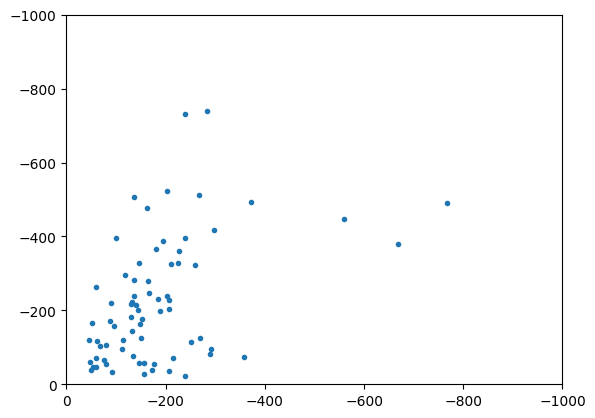

In [55]:
plt.plot(tmp_amps[0],tmp_amps[3],'.')
plt.xlim([0,-1000])
plt.ylim([0,-1000])
plt.show()

In [ ]:
amps = [s.get_extension("spike_amplitudes").get_data() for s in sorting_analyzer]

(607528,)

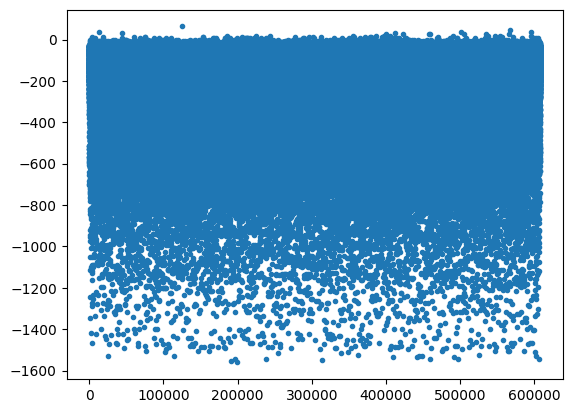

In [43]:
plt.plot(amps[0],'.')
plt.show()